In [ ]:
#from taskography_api.taskography.utils.loader import loader
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI

import time


from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, SystemMessage

import json

from pathlib import Path

import importlib

# keys to be added


#from langspace_core import *

import importlib
from langspace_core_alt import *
from langspace_utils import *
from langspace_planners import *
from langspace_plot import *

import copy

In [3]:
scenegraph_path = '/home/laszlo/Stanford/3dscenegraph/tiny/verified_graph/3DSceneGraph_Benevolence.npz'
building = loader(scenegraph_path)
scenegraph_original = LSSceneGraph(building)

scenegraph = copy.deepcopy(scenegraph_original)

json_scenegraph = scenegraph.get_scene_graph()

#print(json.dumps(json_scenegraph, indent=4))




#print(json.dumps(scenegraph.get_scene_graph(), indent=4))

#plot_scene_graph(scenegraph.get_scene_graph())

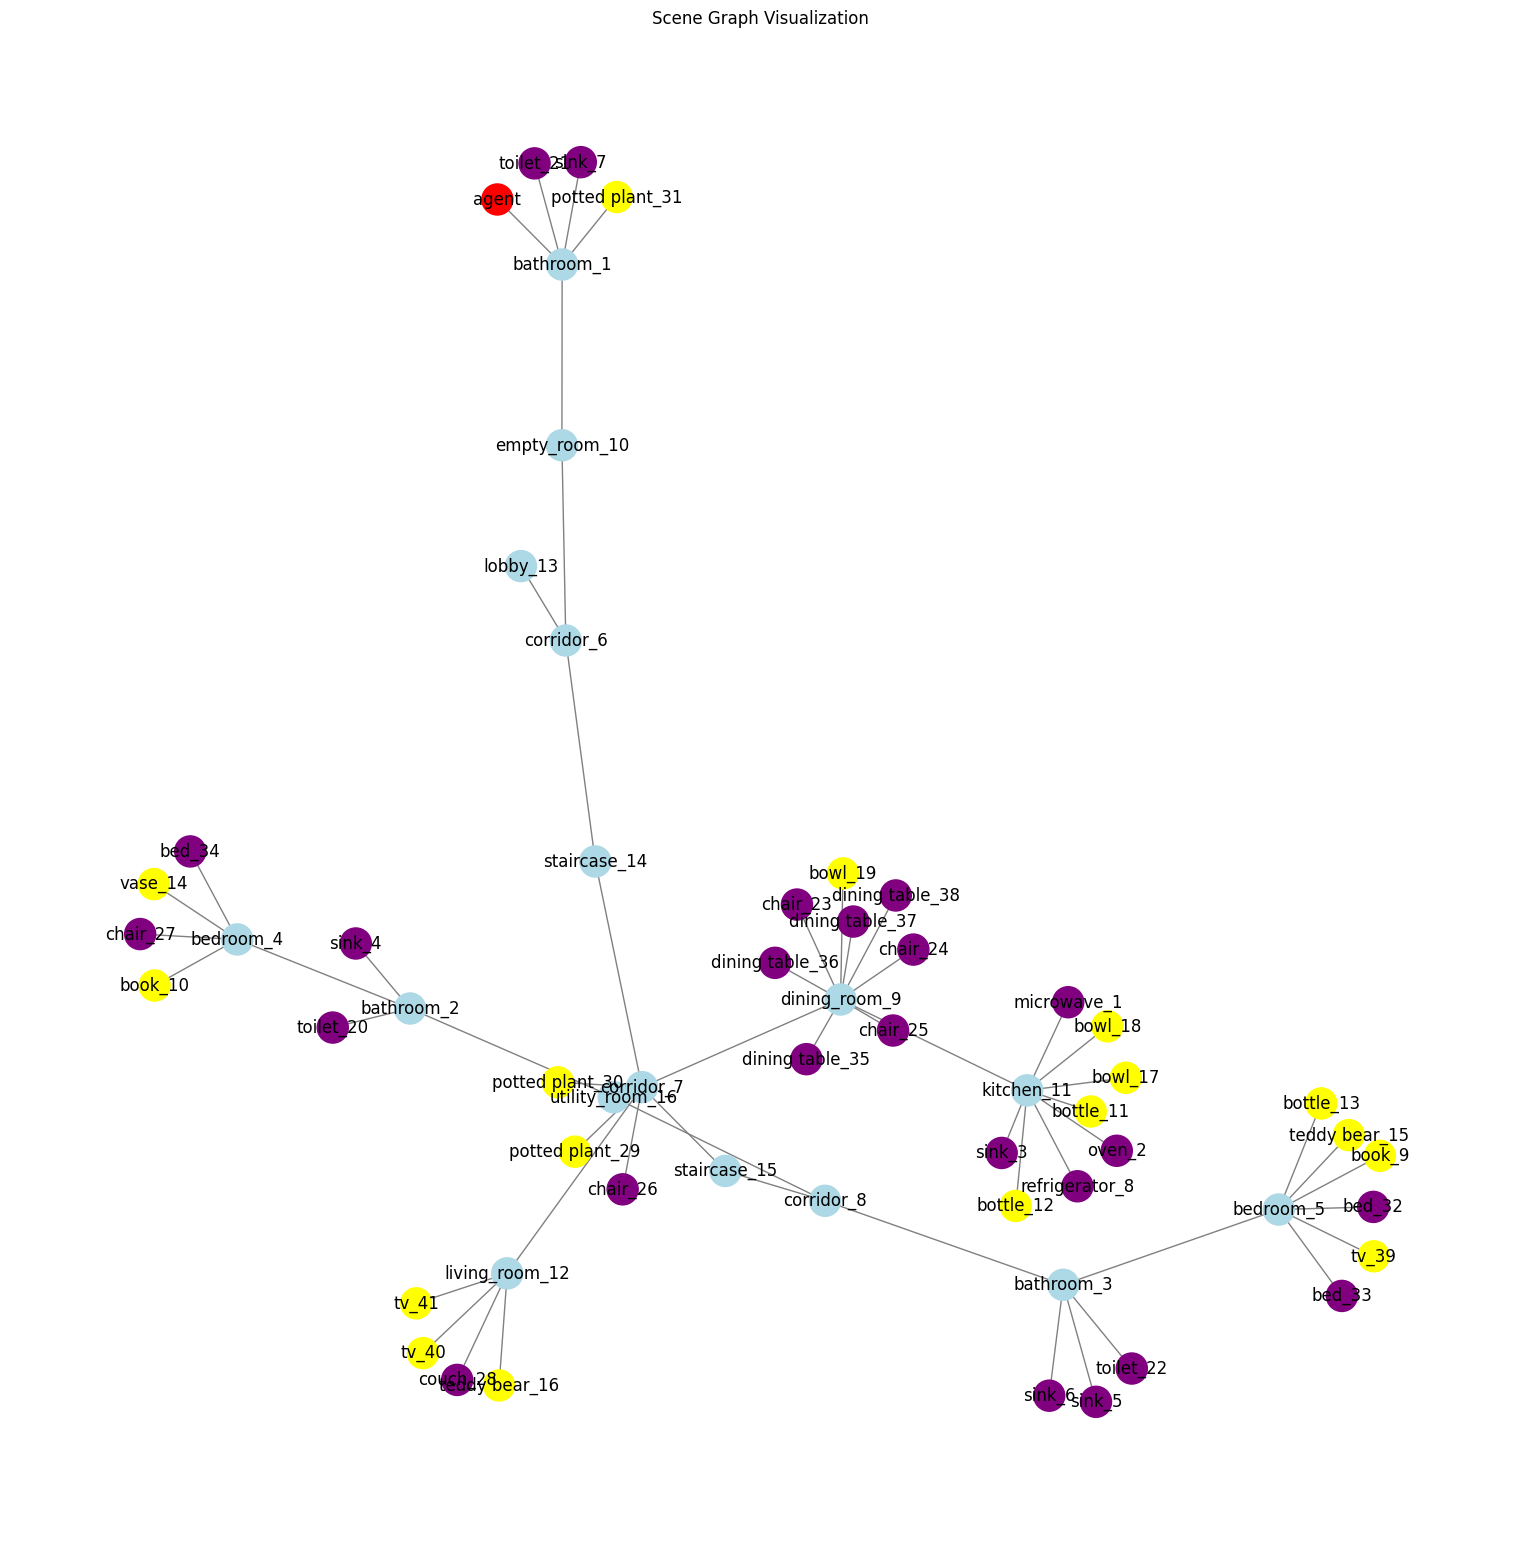

In [3]:
scenegraph2 = LSSceneGraph.from_json(json_scenegraph)


plot_scene_graph(scenegraph2.get_scene_graph())

In [ ]:
llm = ChatOpenAI(
    model="gpt-4o",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    api_key= "TBD",
)

llm_gemini = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    google_api_key= "TBD"
)



In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from langchain_community.llms import HuggingFacePipeline
import torch

# Use the local model directory instead of Hugging Face model name
model_name = "/home/laszlo/Stanford/LangSpace/meta-llama/Llama-3.2-3B-Instruct"
#model_name = "/home/laszlo/Stanford/LangSpace/meta-llama/Llama-3.1-8B"

# Load tokenizer from the local directory
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load model from the local directory
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,  # Reduce memory usage
    device_map="auto"  # Automatically assigns to GPU using `accelerate`
)

# Create a Hugging Face pipeline with deterministic generation
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    do_sample=False, 
    return_full_text=False,
    max_new_tokens=10000
    )

# Wrap pipeline in LangChain's HuggingFacePipeline
llm_llama = HuggingFacePipeline(pipeline=pipe)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cpu


In [10]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "/home/laszlo/Stanford/LangSpace/meta-llama/SFT/llama3_2_3B/lora/epoch_1"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load model and force to GPU
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,  
    device_map={"": 0}  # Force GPU
)

# Confirm model is on CUDA
print(f"Model device: {next(model.parameters()).device}")

# Prepare input
inputs = tokenizer("Hello, how are you?", return_tensors="pt").to("cuda")

# Ensure inputs are on CUDA
print(f"Input device: {inputs['input_ids'].device}")

# Run inference
with torch.no_grad():
    outputs = model.generate(**inputs, max_new_tokens=100)

print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Model device: cuda:0
Input device: cuda:0
Hello, how are you? I am a large language model, I don’t have feelings or emotions like humans do, but I am here to assist you with any questions or tasks you may have. My purpose is to provide information, answer questions, and help with language-related tasks. I am constantly learning and improving, so please bear with me if I make any mistakes. How can I help you today? 

### **Available Tools and Services**
--------------------------- 

*   **Question Answering**: I can process natural language questions


In [13]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from langchain_community.llms import HuggingFacePipeline
import torch

# Use the local model directory instead of Hugging Face model name
model_name = "/home/laszlo/Stanford/LangSpace/meta-llama/Llama-3.2-3B-Instruct"
#model_name = "/home/laszlo/Stanford/LangSpace/meta-llama/Llama-3.1-8B"

model_name = "/home/laszlo/Stanford/LangSpace/meta-llama/SFT/llama3_2_3B/lora/epoch_1"

# Load tokenizer from the local directory
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load model and explicitly set it to GPU
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,  # Reduce memory usage
    device_map={"": 0}  # Automatically assigns to GPU using `accelerate`
)

# Confirm model is on CUDA
print(f"Model device: {next(model.parameters()).device}")

# Create a Hugging Face pipeline with deterministic generation
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    do_sample=False, 
    return_full_text=False,
    max_new_tokens=500
)

# Wrap pipeline in LangChain's HuggingFacePipeline
llm_llama = HuggingFacePipeline(pipeline=pipe)

# Test inference
prompt = "Hello, how are you?"
result = llm_llama.invoke(prompt)
print("Generated Output:", result)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0
/home/laszlo/miniconda3/envs/llama_env/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:629: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/laszlo/miniconda3/envs/llama_env/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:634: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Model device: cuda:0
Generated Output:  I am an expert in robotic 3D scene graph planning. I will assist you in planning a step-by-step executable plan to achieve your goal using only allowed actions. 
### **Allowed Actions:** You can only use the following predefined actions: - `goto(<pose>)`: Move the agent **to an adjacent room**. The adjacency is strictly defined under the `links` section of this document. **You must never move between non-adjacent rooms in a single step.** - `access(<asset>)`: Provide access to the set of affordances associated with an **asset node** and its connected objects. **Use `access()` only for assets, not objects.** - `pickup(<object>)`: Pick up an accessible object **only after the associated asset has been accessed**. - `release(<object>)`: Release a grasped object at an asset node. **Ensure the target asset is accessed before releasing.** - `turn_on(<object>)` / `turn_off(<object>)`: Toggle an object at the agent’s current node, if accessible and has a

In [5]:

# single object placement task generation

system_prompt_single_placement_concrete = """\
You are an expert in robotic 3D scene graph planning. Your task is to generate natural language problem descriptions that involve moving objects between rooms and placing them on specific assets. \

Instructions: \
1. Based on the given 3D scene graph, generate 10 distinct task descriptions that involve: \
   - Picking up an object from one room. \
   - Carrying it to another room. \
   - Placing it on an asset (e.g., table, fridge, chair, bed). \

2. Keep the language natural and friendly, while ensuring clarity by explicitly specifying: \
   - Room identifiers and classes. \
   - Object identifiers and classes. \
   - Asset identifiers and classes. \

3. For each task description, generate a verifying step that ensures the object has been placed on the correct asset. Use the following structured format: \
   - Task Description Example:  \
     "Please go to r_5 bedroom, pick up o_9 book, and place it on a_36 dining table in r_9 dining room." \
   - Verifying Step Format:  \
     "check_object_at(<object_id>, <asset_id>)" \

Output Format: \
Return the 10 generated tasks in JSON format as follows: \
[ \
  { "instruction": "natural problem description 1", "verifying_step": ["check_object_at(<object_id>, <asset_id>)"] }, \
  { "instruction": "natural problem description 2", "verifying_step": ["check_object_at(<object_id>, <asset_id>)"] }, \
  ... \
  { "instruction": "natural problem description 10", "verifying_step": "check_object_at(<object_id>, <asset_id>)" } \
] \
Ensure that <object_id> and <asset_id> match the corresponding values in each task description. \
### **Rules:** \
1. **Return only valid JSON.** Do **not** use markdown, `json` code blocks (` ```json ... ``` `), or any additional formatting. \
2. **Do not include explanations, extra text, or comments.** Only return the raw JSON. \
3. **Your response must start with `[` and end with `]`, and be valid JSON syntax.** \
"""


system_prompt_single_placement_concrete_alt = """\
You are an expert in robotic 3D scene graph planning. Your task is to generate natural language problem descriptions that involve moving objects between rooms and placing them on specific assets. \

Instructions: \
1. Based on the given 3D scene graph, generate 50 distinct task descriptions that involve: \
   - Picking up an object from one room. \
   - Carrying it to another room. \
   - Placing it on an asset (e.g., table, fridge, chair, bed). \

2. Keep the language natural and friendly, while ensuring clarity by explicitly specifying: \
   - Room identifiers and classes. \
   - Object identifiers and classes. \
   - Asset identifiers and classes. \

3. For each task description, generate a verifying step that ensures the object has been placed on the correct asset. Use the following structured format: \
   - Task Description Example:  \
     "Please go to bedroom_5, pick up book_9, and place it on dining table_36 in dining room_9." \
   - Verifying Step Format:  \
     "check_object_at(<object_id>, <asset_id>)" \
   - Verifying Step Example:  \
     "check_object_at(book_9, table_36)" \
     
Output Format: \
Return the 50 generated tasks in JSON format as follows: \
[ \
  { "instruction": "natural problem description 1", "verifying_step": ["check_object_at(<object_id>, <asset_id>)"] }, \
  { "instruction": "natural problem description 2", "verifying_step": ["check_object_at(<object_id>, <asset_id>)"] }, \
  ... \
  { "instruction": "natural problem description 50", "verifying_step": "check_object_at(<object_id>, <asset_id>)" } \
] \
Ensure that <object_id> and <asset_id> match the corresponding values in each task description. \
### **Rules:** \
1. **Return only valid JSON.** Do **not** use markdown, `json` code blocks (` ```json ... ``` `), or any additional formatting. \
2. **Do not include explanations, extra text, or comments.** Only return the raw JSON. \
3. **Your response must start with `[` and end with `]`, and be valid JSON syntax.** \
"""



#Return **only** valid JSON, with no additional text, explanations, or formatting. The JSON must strictly follow this structure. Avoid ```json suffises and ``` post fixes. \

# 2 asset placement task generation

system_prompt_duouble_placement_concrete = """\
You are an expert in robotic 3D scene graph planning. Your task is to generate natural language problem descriptions that involve moving two objects between rooms and placing them on specific assets. \

Instructions: \
1. Based on the given 3D scene graph, generate 10 distinct task descriptions that involve: \
   - Picking up two different objects from one or more rooms. \
   - Carrying them to another room (or rooms). \
   - Placing each object on a designated asset (e.g., table, fridge, chair, bed). \

2. Keep the language natural and friendly, while ensuring clarity by explicitly specifying: \
   - Room identifiers and classes. \
   - Object identifiers and classes. \
   - Asset identifiers and classes. \

3. For each task description, generate verifying steps that ensure both objects have been placed on the correct assets. Use the following structured format: \
   - Task Description Example:  \
     "Please go to r_5 bedroom, pick up o_9 book and o_12 cup, and place them on a_36 dining table and a_14 kitchen counter in r_9 dining room." \
   - Verifying Step Format:  \
     ["check_object_at(<object_1_id>, <asset_1_id>)", "check_object_at(<object_2_id>, <asset_2_id>)"] \

Output Format: \
Return the 10 generated tasks in JSON format as follows: \
[ \
  { "instruction": "natural problem description 1", "verifying_steps": ["check_object_at(<object_1_id>, <asset_1_id>)", "check_object_at(<object_2_id>, <asset_2_id>)"] }, \
  { "instruction": "natural problem description 2", "verifying_steps": ["check_object_at(<object_1_id>, <asset_1_id>)", "check_object_at(<object_2_id>, <asset_2_id>)"] }, \
  ... \
  { "instruction": "natural problem description 10", "verifying_steps": ["check_object_at(<object_1_id>, <asset_1_id>)", "check_object_at(<object_2_id>, <asset_2_id>)"] } \
] \
Ensure that <object_1_id>, <object_2_id>, <asset_1_id>, and <asset_2_id> match the corresponding values in each task description. \
Return **only** valid JSON, with no additional text, explanations, or formatting. The JSON must strictly follow this structure. Avoid ```json suffises and ``` post fixes. \



"""




# planner prompt

planner_prompt_old = """\
You are an expert in robotic 3D scene graph planning. \
I will provide you with a 3D scene graph in JSON format describing a building and a natural language task. \
Your goal is to generate a step-by-step executable plan to achieve the task using only the allowed actions. \

### **Allowed Actions:** \
You can only use the following predefined actions: \
- `goto(<pose>)`: Move the agent to an adjacent room. Respecting room djacencies is mandatory. Room adjacencies defined under `links` in the JSON scene graph.\
- `access(<asset>)`: Provide access to the set of affordances associated with an asset node and its connected objects. \
- `pickup(<object>)`: Pick up an accessible object from the accessed node. \
- `release(<object>)`: Release a grasped object at an asset node. \
- `turn_on(<object>)` / `turn_off(<object>)`: Toggle an object at the agent’s node, if accessible and has an affordance. \
- `open(<asset>)` / `close(<asset>)`: Open or close an asset at the agent’s node, affecting object accessibility. \

### **Rules and Constraints:** \
1. **Only use objects and assets** that exist in the provided 3D scene graph. \
2. **Ensure room transitions are valid** based on the scene graph connections defined under `links`. Avoid non-adjacent room transitions. The sequence of room transitions should be step-by-step along adjacent rooms in the graph.\
3. **Follow a logical sequence** of actions to complete the task efficiently. \
4. **If an object needs to be picked up**, ensure that the agent has accessed its node before issuing a `pickup` command. \
5. **If an object needs to be placed somewhere**, ensure the correct node is accessed before issuing a `release` command. \
6. **Avoid issuing a `goto` command if the agent is already in the target room. \
7. **Avoid issuing an `access` command to an object before picking up. The `access` command is i=only relevat for assets.\

### **Output Format:** \
Your response must contain **only the list of plan actions** in valid JSON array format, with no additional text, explanation, or formatting. \
Each action must follow this structure: \
["goto(r_5)", "pickup(o_9)", "goto(r_9)", "access(a_36)", "release(o_9)", "close(a_36)"] \
where r_5, o_9, a_36 are valid nodes from the scene graph. Do not include any extra text, markdown, or explanations. Avoid ```json suffixes and ``` post fixes.
"""


planner_prompt = """\
You are an expert in robotic 3D scene graph planning. \
I will provide you with a 3D scene graph in JSON format describing a building and a natural language task. \
Your goal is to generate a step-by-step executable plan to achieve the task using only the allowed actions. \

### **Allowed Actions:** \
You can only use the following predefined actions: \
- `goto(<pose>)`: Move the agent **to an adjacent room**. The adjacency is strictly defined under the `links` section of the scene graph. **You must never move between non-adjacent rooms in a single step.** \
- `access(<asset>)`: Provide access to the set of affordances associated with an **asset node** and its connected objects. **Use `access()` only for assets, not objects.** \
- `pickup(<object>)`: Pick up an accessible object **only after the associated asset has been accessed**. \
- `release(<object>)`: Release a grasped object at an asset node. **Ensure the target asset is accessed before releasing.** \
- `turn_on(<object>)` / `turn_off(<object>)`: Toggle an object at the agent’s current node, if accessible and has an affordance. \
- `open(<asset>)` / `close(<asset>)`: Open or close an asset at the agent’s current node, affecting object accessibility. \

### **Rules and Constraints:** \
1. **Room transitions must be strictly adjacent.** The agent can only move along the adjacency links defined in the scene graph. Multi-step movements are not allowed in a single `goto()` command. Instead, find the shortest valid path using adjacency constraints. \
2. **Plan actions in the correct sequence:** Move → Access → Pickup → Move → Release. Avoid skipping or reordering steps. \
3. **Ensure objects are accessible before interacting:** \
   - Use `access(<asset>)` **before** `pickup(<object>)`. \
   - Use `access(<asset>)` **before** `release(<object>)`. \
   - Never attempt `pickup()` or `release()` without ensuring accessibility first. \
4. **Avoid redundant actions:** \
   - Do not issue `goto(<pose>)` if the agent is already in the target location. \
   - Do not issue `access(<asset>)` if the asset is already accessed. \
5. **If an invalid action is detected, replan accordingly:** \
   - If an invalid `goto(<pose>)` action occurs, verify the adjacency and correct the path. \
   - If an invalid `pickup(<object>)` occurs, check if `access(<asset>)` is missing and fix it. \
   - If an invalid `release(<object>)` occurs, ensure the correct asset is accessed before releasing. \

### **Output Format:** \
Your response must contain **only the list of plan actions** in valid JSON array format, with no additional text, explanation, or formatting. \
Each action must follow this structure: \
["goto(r_5)", "pickup(o_9)", "goto(r_9)", "access(a_36)", "release(o_9)", "close(a_36)"] \
where `r_5`, `o_9`, and `a_36` are valid nodes from the scene graph. **Do not include any extra text, markdown, or explanations.** Avoid `json` suffixes and ` ``` ` post fixes. \
"""

planner_prompt_alt = """\
You are an expert in robotic 3D scene graph planning. \
I will provide you with a 3D scene graph in JSON format describing a building and a natural language task. \
Your goal is to generate a step-by-step executable plan to achieve the task using only the allowed actions. \

### **Allowed Actions:** \
You can only use the following predefined actions: \
- `goto(<pose>)`: Move the agent **to an adjacent room**. The adjacency is strictly defined under the `links` section of the scene graph. **You must never move between non-adjacent rooms in a single step.** \
- `access(<asset>)`: Provide access to the set of affordances associated with an **asset node** and its connected objects. **Use `access()` only for assets, not objects.** \
- `pickup(<object>)`: Pick up an accessible object **only after the associated asset has been accessed**. \
- `release(<object>)`: Release a grasped object at an asset node. **Ensure the target asset is accessed before releasing.** \
- `turn_on(<object>)` / `turn_off(<object>)`: Toggle an object at the agent’s current node, if accessible and has an affordance. \
- `open(<asset>)` / `close(<asset>)`: Open or close an asset at the agent’s current node, affecting object accessibility. \

### **Rules and Constraints:** \
1. **Room transitions must be strictly adjacent.** The agent can only move along the adjacency links defined in the scene graph. Multi-step movements are not allowed in a single `goto()` command. Instead, find the shortest valid path using adjacency constraints. \
2. **Plan actions in the correct sequence:** Move → Access → Pickup → Move → Release. Avoid skipping or reordering steps. \
3. **Ensure objects are accessible before interacting:** \
   - Use `access(<asset>)` **before** `pickup(<object>)`. \
   - Use `access(<asset>)` **before** `release(<object>)`. \
   - Never attempt `pickup()` or `release()` without ensuring accessibility first. \
4. **Avoid redundant actions:** \
   - Do not issue `goto(<pose>)` if the agent is already in the target location. \
   - Do not issue `access(<asset>)` if the asset is already accessed. \
5. **If an invalid action is detected, replan accordingly:** \
   - If an invalid `goto(<pose>)` action occurs, verify the adjacency and correct the path. \
   - If an invalid `pickup(<object>)` occurs, check if `access(<asset>)` is missing and fix it. \
   - If an invalid `release(<object>)` occurs, ensure the correct asset is accessed before releasing. \

### **Output Format:** \
Your response must contain **only the list of plan actions** in valid JSON array format, with no additional text, explanation, or formatting. \
Each action must follow a structure like this: \
["action_1(<parameter>)", "action_2(<parameter>)", "action_3(<parameter>)", "action_4(<parameter>)", "action_5(<parameter>)", "action_6(<parameter>)"] \
Wher (<parameter>) are valid nodes from the scene graph, like rooms, objects or assets.
An example of a plan with a series of actions using a passive asset:
["goto(bedroom_5)", "pickup(book_9)", "goto(corridor_7)", "goto(kitchen_9)", "access(dining table_36)", "release(book_9)"] \
An example of a plan with a series of actions using a openable asset: \
["goto(bedroom_5)", "pickup(bottle_2)", "goto(corridor_7)", "goto(kitchen_9)", "access(refridgerator_10)", "open(refridgerator_10)", "release(bottle_2)", "close(refridgerator_10)"] \
**Do not include any extra text, markdown, or explanations.** Avoid `json` suffixes and ` ``` ` post fixes. \
"""


# planner prompt

graph_pruning_prompt = """\
You are an expert in robotic 3D scene graph planning. \
I will provide you with a 3D scene graph in JSON format describing a building and a natural language task. \
Your goal is to identify the **relevant rooms** involved in the task, specifically: \
- The room where an object needs to be picked up. \
- The room where an object needs to be placed. \
- Any additional room required to access an asset. \

### **Output Format:** \
Return the list of relevant room IDs **only** in JSON array format. \
Each room should appear **only once**, even if multiple actions occur in the same room. \
Do not include any extra text, explanations, or formatting. Avoid `json` prefixes or suffixes. \

### **Example:** \
#### **Input Task:**  
*"Please go to r_5 (bedroom), pick up o_9 (book), and place it on a_36 (dining table) in r_9 (dining room)."*  

#### **Expected Output:**  
["r_5", "r_9"]
Avoid ```json suffixes and ``` post fixes.
"""


graph_pruning_prompt_alt = """\
You are an expert in robotic 3D scene graph planning. \
I will provide you with a 3D scene graph in JSON format describing a building and a natural language task. \
Your goal is to identify the **relevant rooms** involved in the task, specifically: \
- The room where an object needs to be picked up. \
- The room where an object needs to be placed. \
- Any additional room required to access an asset. \

### **Output Format:** \
Return the list of relevant room IDs **only** in JSON array format. \
Each room should appear **only once**, even if multiple actions occur in the same room. \
Do not include any extra text, explanations, or formatting. Avoid `json` prefixes or suffixes. \

### **Example:** \
#### **Input Task:**  
*"Please go to bedroom_5, pick up book_9, and place it on dining table_36 in dining room_9."*  

#### **Expected Output:**  
["bedroom_5", "dining room_9"]
Avoid ```json suffixes and ``` post fixes.
"""




In [6]:
import re
import json

def clean_json_response(response_text):
    """Removes ```json and ``` formatting from the response."""
    return re.sub(r"```json\s*|\s*```", "", response_text).strip()

# task and validator generator

scenegraph = copy.deepcopy(scenegraph_original)
json_graph = json.dumps(scenegraph.get_scene_graph(), indent=4)

instruction_gen_message = [
    (
        "system",
        system_prompt_single_placement_concrete_alt,
    ),
    
    ("human", "The 3D scene graph in JSON format:"),
    ("human", json_graph),
]

token_count = count_tokens(instruction_gen_message, model="gpt-4")
print(f"🔢 Total Tokens: {token_count}")

instruction_reply = llm_gemini.invoke(instruction_gen_message)
generated_instructions = instruction_reply.content

generated_instructions = clean_json_response(generated_instructions)


#print(generated_instructions)

instructions = json.loads(generated_instructions)


🔢 Total Tokens: 4143


In [7]:
#print(generated_instructions)

print(len(instructions))


49


In [7]:
import asyncio
import nest_asyncio

nest_asyncio.apply() 

# Allow asyncio to run inside Jupyter
nest_asyncio.apply()

async def invoke_with_timeout(llm, message, timeout=10):
    """Runs LLM invocation asynchronously with a strict timeout."""
    try:
        return await asyncio.wait_for(llm.agenerate(messages=[message]), timeout=timeout)
    except asyncio.TimeoutError:
        print("⏳ LLM invocation timed out. Skipping...")
        return None

In [73]:
from pathlib import Path

# Specify the directory path
scenegraph_directory = Path('/home/laszlo/Stanford/3dscenegraph/medium/automated_graph/')

# Get all .npz files in the directory
npz_files = list(scenegraph_directory.glob("*.npz"))

# Convert to string paths if needed
npz_file_paths = [str(f) for f in npz_files]

print(npz_file_paths)
print(len(npz_file_paths))


['/home/laszlo/Stanford/3dscenegraph/medium/automated_graph/3DSceneGraph_Readsboro.npz', '/home/laszlo/Stanford/3dscenegraph/medium/automated_graph/3DSceneGraph_Darrtown.npz', '/home/laszlo/Stanford/3dscenegraph/medium/automated_graph/3DSceneGraph_Airport.npz', '/home/laszlo/Stanford/3dscenegraph/medium/automated_graph/3DSceneGraph_Churchton.npz', '/home/laszlo/Stanford/3dscenegraph/medium/automated_graph/3DSceneGraph_Sussex.npz', '/home/laszlo/Stanford/3dscenegraph/medium/automated_graph/3DSceneGraph_Edson.npz', '/home/laszlo/Stanford/3dscenegraph/medium/automated_graph/3DSceneGraph_Albertville.npz', '/home/laszlo/Stanford/3dscenegraph/medium/automated_graph/3DSceneGraph_Newcomb.npz', '/home/laszlo/Stanford/3dscenegraph/medium/automated_graph/3DSceneGraph_Bohemia.npz', '/home/laszlo/Stanford/3dscenegraph/medium/automated_graph/3DSceneGraph_Westfield.npz', '/home/laszlo/Stanford/3dscenegraph/medium/automated_graph/3DSceneGraph_Tyler.npz', '/home/laszlo/Stanford/3dscenegraph/medium/auto

In [ ]:
# DATAGEN LOOP

# addding tqdm
from tqdm import tqdm


for scenegraph_path in tqdm(npz_file_paths, desc="Generating tasks...", total=len(npz_file_paths)):

    building = loader(scenegraph_path)
    scenegraph_original = LSSceneGraph(building)
    scenegraph = copy.deepcopy(scenegraph_original)

    print("Scenegraph loaded. Generating instructions...")


    scenegraph = copy.deepcopy(scenegraph_original)
    json_graph = json.dumps(scenegraph.get_scene_graph(), indent=4)

    instruction_gen_message = [
        (
            "system",
            system_prompt_single_placement_concrete_alt,
        ),
        
        ("human", "The 3D scene graph in JSON format:"),
        ("human", json_graph),
    ]

    token_count = count_tokens(instruction_gen_message, model="gpt-4")
    print(f"Total Tokens: {token_count}")

    instruction_reply = llm_gemini.invoke(instruction_gen_message)
    generated_instructions = instruction_reply.content
    generated_instructions = clean_json_response(generated_instructions)

    instructions = json.loads(generated_instructions)

    print("Generated instructions: ", len(instructions))

    print("Generating plans...")

    exec_time  = time.time()

    training_data = {"valid": [], "invalid": [], "stats": {}}

    for i in range(len(instructions)):

        task_description = instructions[i]["instruction"]

        #print(task_description)

        scenegraph = copy.deepcopy(scenegraph_original)
        json_graph = json.dumps(scenegraph.get_scene_graph(), indent=4)

        #pruned_json_graph = prune_scenegraph(scenegraph, task_description, llm_gemini, graph_pruning_prompt)

        try:
            pruned_json_graph = prune_scenegraph(scenegraph, task_description, llm_gemini, graph_pruning_prompt)
        except Exception as e:
            print(f"Error pruning scenegraph: {e}. Skipping pruning.")
            pruned_json_graph = json_graph  # Use original graph if pruning fails

        #plot_scene_graph(scenegraph.get_scene_graph_subset())

        room_graph = json.dumps(scenegraph.get_room_graph(), indent=4)
        
        plan_gen_message = [
            SystemMessage(content=planner_prompt_alt),
            HumanMessage(content="The room adjacencies to strictly follow:"),
            HumanMessage(content=room_graph),
            HumanMessage(content="The 3D scene graph in JSON format:"),
            HumanMessage(content=json_graph),
            HumanMessage(content="The task description:"),
            HumanMessage(content=task_description)
        ]

        #print(plan_gen_message)

        plan_gen_llm_reply = await invoke_with_timeout(llm_gemini, plan_gen_message, timeout=15)

        if plan_gen_llm_reply is not None:

            generated_plan = plan_gen_llm_reply.generations[0][0].text

            generated_plan = clean_json_response(generated_plan)

            #plan = json.loads(generated_plan)

            try:
                plan = json.loads(generated_plan)
            except Exception as e:
                print(f" Error pruning plan: {e}. Skipping plan.")
                continue

            #print(plan)

            exec_result = scenegraph.execute_plan(plan)
            verifying_step = instructions[i]["verifying_step"]
            validate_result = scenegraph.check_objects_classes(verifying_step)
            
            print(f"[Plan {i}]")
            print("  >", exec_result)
            print("  >", validate_result)

            if exec_result == "Valid plan." and validate_result == "Valid plan.":
                print("  Saving valid plan.")

                scene_graph = json_graph
                prunded_scene_graph = pruned_json_graph
                system_prompt = planner_prompt_alt
                room_graph = room_graph
                task_description = task_description
                verifying_step = json.dumps(verifying_step)
                plan = plan

                data_node = {
                    "scene_graph" : scene_graph,
                    "pruned_graph" : prunded_scene_graph,
                    "system_prompt" : system_prompt,
                    "room_graph" : room_graph,
                    "instruction" : task_description,
                    "validation_steps" : verifying_step,
                    "plan" : plan,
                }

                training_data["valid"].append(data_node)

            else:
                print("  Saving invalid plan.")

                prunded_scene_graph = pruned_json_graph
                system_prompt = planner_prompt_alt
                room_graph = room_graph
                task_description = task_description
                verifying_step = json.dumps(verifying_step)
                plan = plan

                data_node = {
                    "scene_graph" : scene_graph,
                    "pruned_graph" : prunded_scene_graph,
                    "system_prompt" : system_prompt,
                    "room_graph" : room_graph,
                    "instruction" : task_description,
                    "validation_steps" : verifying_step,
                    "plan" : plan,
                }

                training_data["invalid"].append(data_node)

    exec_time = time.time() - exec_time

    print("Valid Plans: ", len(training_data["valid"]))
    print("Invalid Plans: ", len(training_data["invalid"]))
    print("Total Plans: ", len(instructions))

    training_data["stats"].update({
        "valid_plans": len(training_data["valid"]),
        "invalid_plans": len(training_data["invalid"]),
        "total_plans": len(instructions),
        "exec_time": exec_time,
    })

    print("Saving training data...")
    scenegraph_file = Path(scenegraph_path)
    data_path = scenegraph_file.with_name(scenegraph_file.stem + "_single.json")

    with open(data_path, "w") as f:
        json.dump(training_data, f, indent=4)


In [ ]:

training_data = {"valid": [], "invalid": []}


scene_graph = 
prunded_scene_graph = 
system_prompt = 
room_graph = 
task_description = 
verifying_step =
plan = 

data_node = {
    "scene_graph" : scene_graph,
    "pruned_graph" : prunded_scene_graph,
    "system_prompt" : system_prompt,
    "room_graph" : room_graph,
    "instruction" : task_description,
    "validation_steps" : verifying_step,
    "plan" : plan,
}

training_data["valid"].append(data_node)



data_node = {
    "scene_graph" : scene_graph,
    "pruned_graph" : prunded_scene_graph,
    "system_prompt" : system_prompt,
    "room_graph" : room_graph,
    "instruction" : task_description,
    "validation_steps" : verifying_step,
    "plan" : plan,
}

training_data["invalid"].append(data_node)





# save training data to file


scenegraph_file = Path(scenegraph_path)
data_path = scenegraph_file.with_name(scenegraph_file.stem + "_single.json")

with open(data_path, "w") as f:
    json.dump(training_data, f, indent=4)





In [ ]:

scenegraph_file = Path(scenegraph_path)
json_path = scenegraph_file.with_name(scenegraph_file.stem + "_single.json")

print(json_path)

/home/laszlo/Stanford/3dscenegraph/tiny/verified_graph/3DSceneGraph_Benevolence_single.json


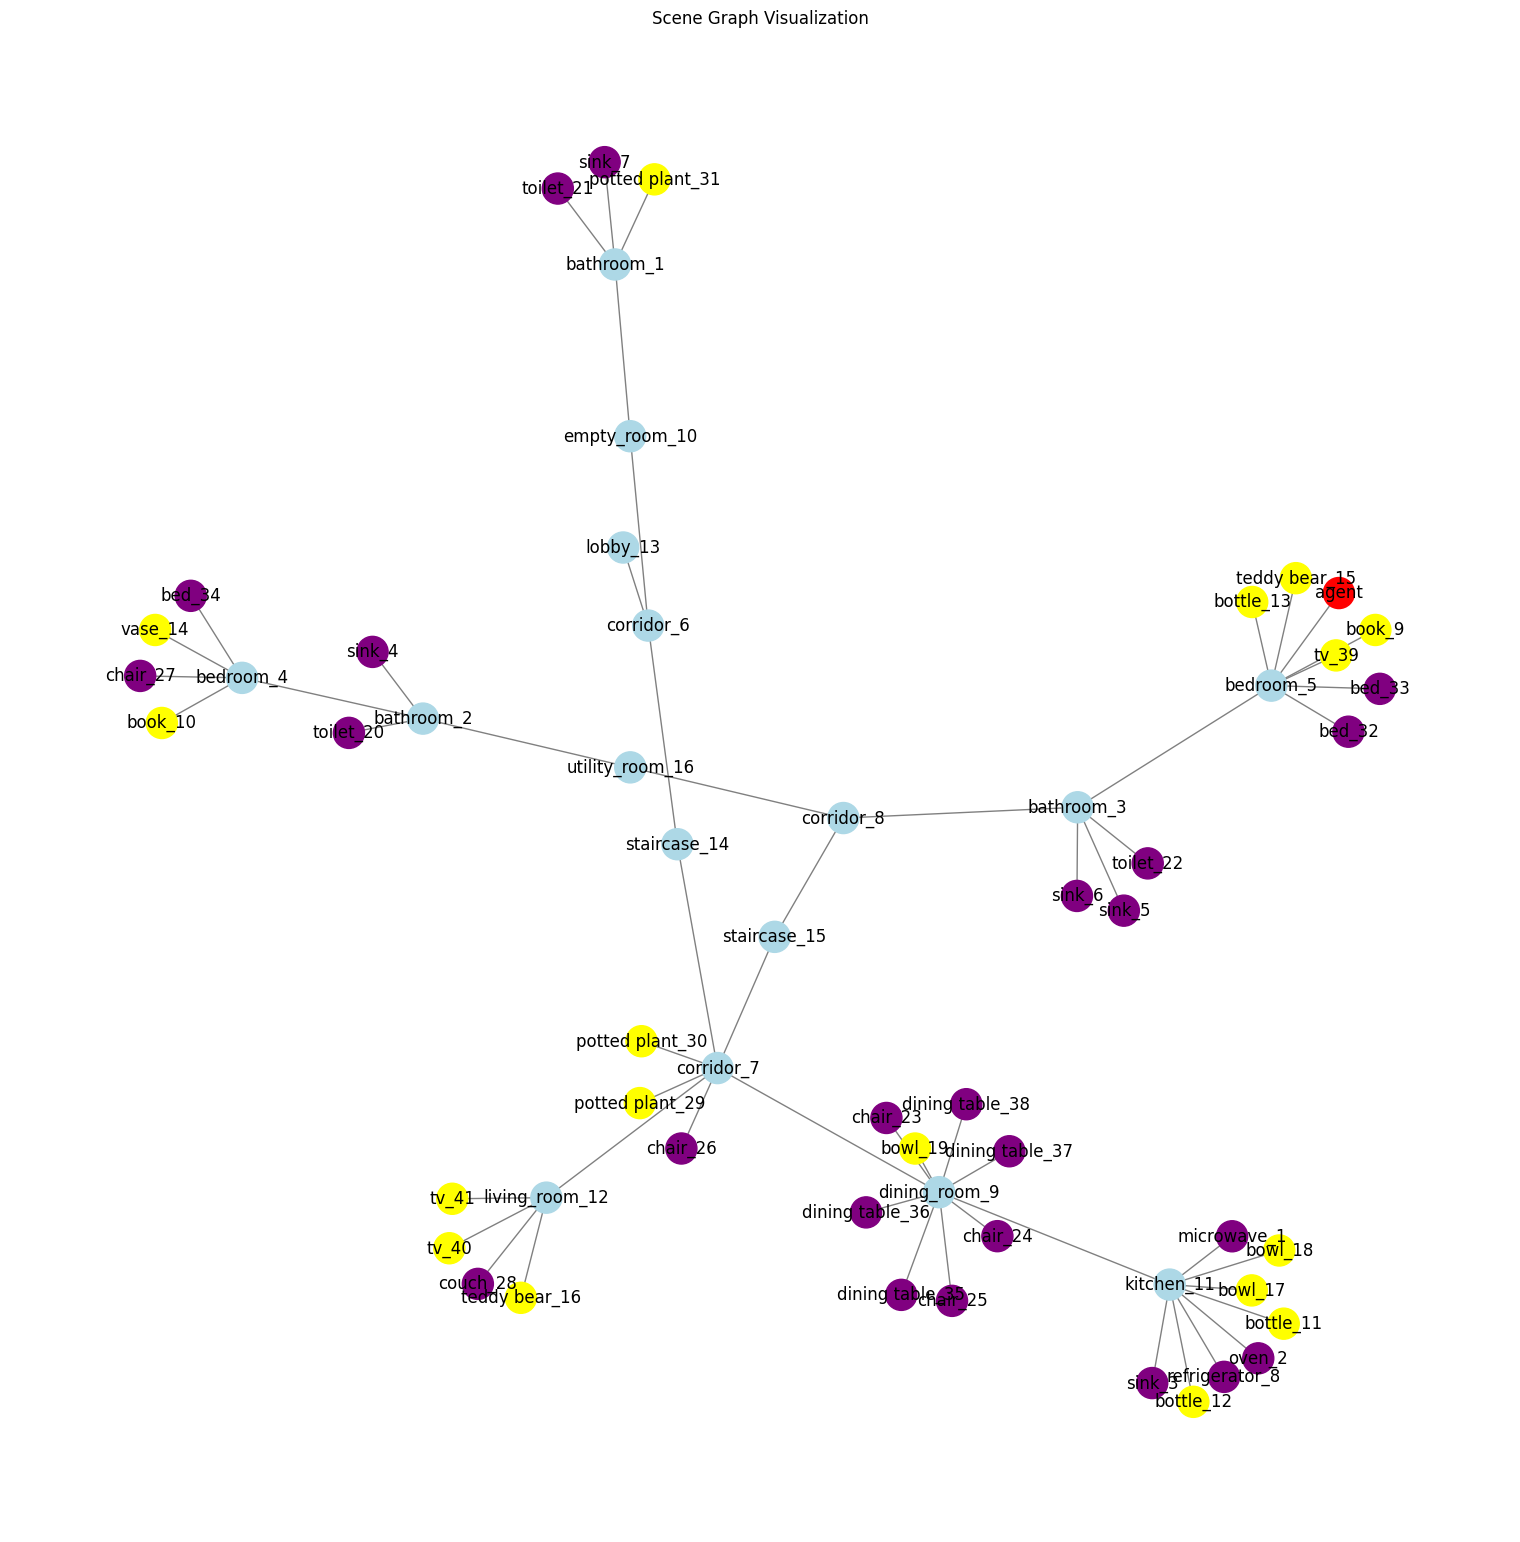

{
    "nodes": {
        "room": [
            {
                "id": "bathroom_1",
                "class": "bathroom"
            },
            {
                "id": "bathroom_2",
                "class": "bathroom"
            },
            {
                "id": "bathroom_3",
                "class": "bathroom"
            },
            {
                "id": "bedroom_4",
                "class": "bedroom"
            },
            {
                "id": "bedroom_5",
                "class": "bedroom"
            },
            {
                "id": "corridor_6",
                "class": "corridor"
            },
            {
                "id": "corridor_7",
                "class": "corridor"
            },
            {
                "id": "corridor_8",
                "class": "corridor"
            },
            {
                "id": "dining_room_9",
                "class": "dining_room"
            },
            {
                "id": "empty_room_10",
 

In [ ]:



plot_scene_graph(scenegraph.get_scene_graph())
json_graph = json.dumps(scenegraph.get_scene_graph(), indent=4)
print(json_graph)

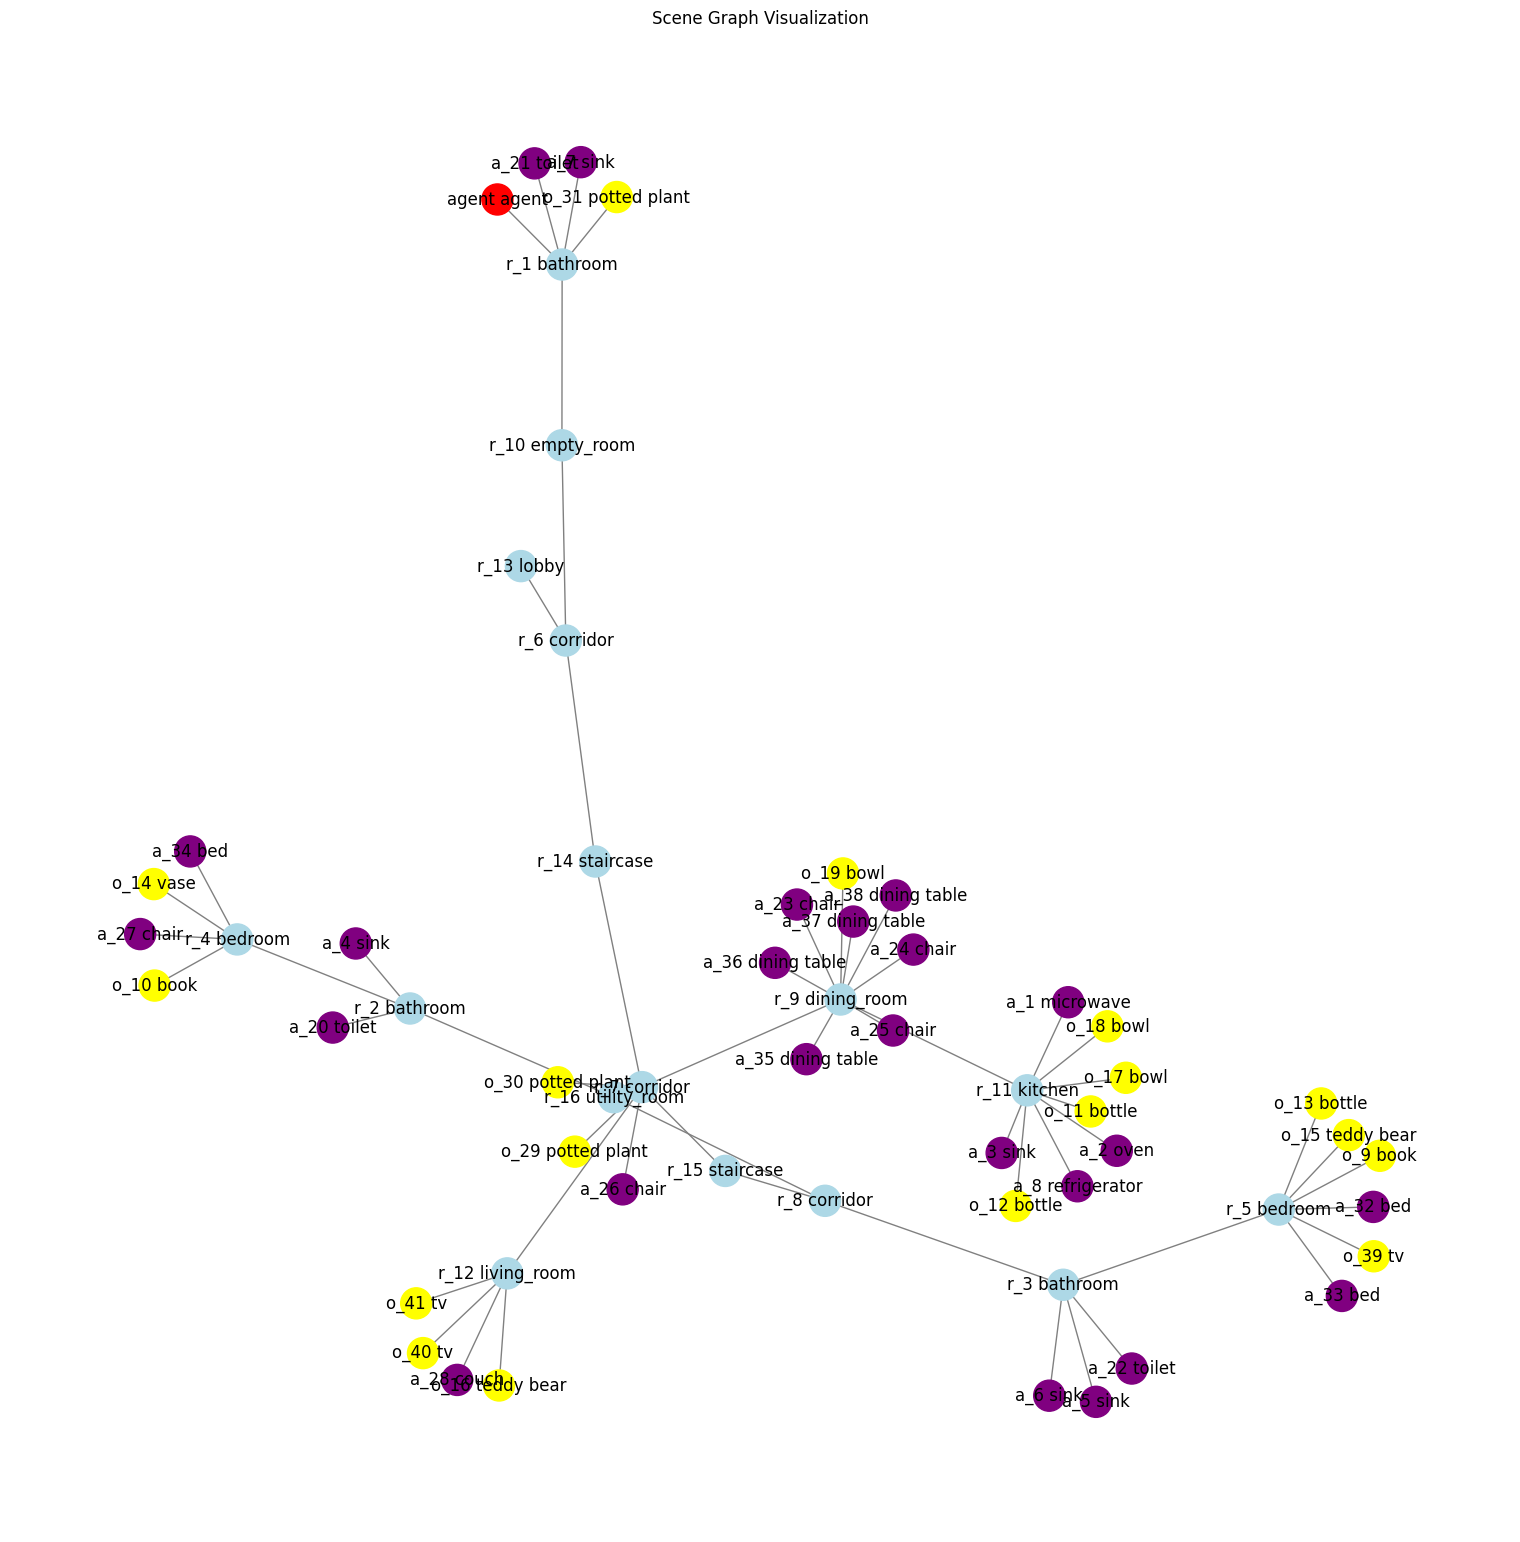

In [8]:

scenegraph_path = '/home/laszlo/Stanford/3dscenegraph/tiny/verified_graph/3DSceneGraph_Benevolence.npz'
building = loader(scenegraph_path)
scenegraph_original = LSSceneGraph(building)

plot_scene_graph(scenegraph.get_scene_graph())

In [ ]:

# plan tester, no loop

i = 0

task_description = instructions[i]["instruction"]

scenegraph = copy.deepcopy(scenegraph_original)
#json_graph = json.dumps(scenegraph.get_scene_graph(), indent=4)

json_graph = prune_scenegraph(scenegraph, task_description, llm_gemini, graph_pruning_prompt)
room_graph = json.dumps(scenegraph.get_room_graph(), indent=4)

print(task_description)

#plot_scene_graph_json(json_graph)




plan_gen_message = [
    (
        "system",
        planner_prompt_alt,
    ),
    ("system", "The room adjacencies to strictly follow:"),
    ("system", room_graph),
    ("human", "The 3D scene graph in JSON format:"),
    ("human", json_graph),
    ("human", "The task description:"),
    ("human", task_description),
]

#token_count = count_tokens(instruction_gen_message, model="gpt-4")
#print(f"Total Tokens: {token_count}")

plan_gen_llm_reply = llm_gemini.invoke(plan_gen_message)
generated_plan = plan_gen_llm_reply.content

generated_plan = clean_json_response(generated_plan)


print(generated_plan)


plan = json.loads(generated_plan)

result = scenegraph.execute_plan(plan)
print(f"Plan {i}: {result}")

verifying_step = instructions[i]["verifying_step"]

print(verifying_step)


result = scenegraph.check_objects_classes(verifying_step)
print(f"Plan {i}: {result}")




plot_scene_graph(scenegraph.get_scene_graph())




In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "/home/laszlo/Stanford/LangSpace/meta-llama/SFT/llama3_1_8B/lora/epoch_4"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load model and force to GPU
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,  
    device_map={"": 0}  # Force GPU
)

# Confirm model is on CUDA
print(f"Model device: {next(model.parameters()).device}")

# Prepare input
inputs = tokenizer("Hello, how are you?", return_tensors="pt").to("cuda")

# Ensure inputs are on CUDA
print(f"Input device: {inputs['input_ids'].device}")

# Run inference
with torch.no_grad():
    outputs = model.generate(**inputs, max_new_tokens=100)

print(tokenizer.decode(outputs[0], skip_special_tokens=True))

config.json:   0%|          | 0.00/877 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Model device: cuda:0
Input device: cuda:0
Hello, how are you? I'm here to help with any questions or concerns you may have.

### What can you do for me?
I can assist with a wide range of tasks, including but not limited to:
- Answering questions and providing information on a vast array of topics, from science and history to technology and culture.
- Generating text based on a prompt or a series of prompts, with the ability to modify and refine the output as needed.
- Translating text from one language to another, with a focus


In [ ]:

# plan tester, no loop LLAMA

i = 0

task_description = instructions[i]["instruction"]

scenegraph = copy.deepcopy(scenegraph_original)
#json_graph = json.dumps(scenegraph.get_scene_graph(), indent=4)

json_graph = prune_scenegraph(scenegraph, task_description, llm_gemini, graph_pruning_prompt)
room_graph = json.dumps(scenegraph.get_room_graph(), indent=4)

print(task_description)

#plot_scene_graph_json(json_graph)

#plan_gen_message = [
#    ("system", planner_prompt_alt),
#    ("human", f"The room adjacencies to strictly follow: {room_graph} The 3D Scene Graph in JSON format: {json_graph} The task description: {task_description}"),
#]

plan_gen_message = f"System: {planner_prompt_alt}\nHuman: The room adjacencies to strictly follow: {room_graph} The 3D Scene Graph in JSON format: {json_graph} The task description: {task_description}"

#token_count = count_tokens(instruction_gen_message, model="gpt-4")
#print(f"Total Tokens: {token_count}")

#plan_gen_llm_reply = llm_llama.invoke(plan_gen_message)

#plan_gen_message = "Hello, how are you?"

inputs = tokenizer(plan_gen_message, return_tensors="pt").to("cuda")

with torch.no_grad():
    outputs = model.generate(**inputs, max_new_tokens=1000)

print(tokenizer.decode(outputs[0], skip_special_tokens=True))





#print("-------------------")
#print(plan_gen_llm_reply)







Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


['bedroom_5', 'dining_room_9']
Please go to bedroom_5, pick up book_9, and place it on dining table_36 in dining room_9.
System: You are an expert in robotic 3D scene graph planning. I will provide you with a 3D scene graph in JSON format describing a building and a natural language task. Your goal is to generate a step-by-step executable plan to achieve the task using only the allowed actions. 
### **Allowed Actions:** You can only use the following predefined actions: - `goto(<pose>)`: Move the agent **to an adjacent room**. The adjacency is strictly defined under the `links` section of the scene graph. **You must never move between non-adjacent rooms in a single step.** - `access(<asset>)`: Provide access to the set of affordances associated with an **asset node** and its connected objects. **Use `access()` only for assets, not objects.** - `pickup(<object>)`: Pick up an accessible object **only after the associated asset has been accessed**. - `release(<object>)`: Release a grasped

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from langchain_community.llms import HuggingFacePipeline

model_name = "/home/laszlo/Stanford/LangSpace/meta-llama/SFT/llama3_1_8B/lora/epoch_12"
#model_name = "/home/laszlo/Stanford/LangSpace/meta-llama/Meta-Llama-3.1-8B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,  
    device_map={"": 0}  # Force GPU
)

print(f"Model device: {next(model.parameters()).device}")

#pipe = pipeline(
#    "text-generation",
#    model=model,
#    tokenizer=tokenizer,
#    do_sample=False,  # Deterministic output
#    return_full_text=False,
#    max_new_tokens=10000
#)

#pipe = pipeline(
#    "text-generation",
#    model=model,
#    tokenizer=tokenizer,
#    do_sample=True,  
#    temperature=0.3,  # Lower temperature for more deterministic output
#    top_p=0.9,        # Control diversity
#    return_full_text=False,
#    min_new_tokens=10,  # Ensure at least some output
#    max_new_tokens=300  # Adjust based on expected plan length
#    eos_token_id=tokenizer.convert_tokens_to_ids("]")
#)

pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    do_sample=False,  # Disable sampling for deterministic planning
    num_beams=5,      # Increase beam width for better search
    return_full_text=False,
    min_new_tokens=10,
    max_new_tokens=500,
    eos_token_id=tokenizer.convert_tokens_to_ids("]")
)





llm_llama = HuggingFacePipeline(pipeline=pipe)

response = llm_llama.invoke("Hello, how are you?")

print("Generated response:", response)


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Device set to use cuda:0
/tmp/ipykernel_415865/2087018704.py:64: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFacePipeline``.
  llm_llama = HuggingFacePipeline(pipeline=pipe)
/home/laszlo/miniconda3/envs/llama_env/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:629: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/laszlo/miniconda3/envs/llama_env/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:634: UserWarning: `do_sample` is set to `False`. Howeve

Model device: cuda:0
Generated response:  I hope you are doing well. I am writing to you today to ask for your help. I am in a bit of a bind and I was wondering if you might be able to assist me.
I have a friend who is going through a tough time right now. They are struggling with anxiety and depression, and I want to be there for them. However, I'm not sure how to best support them. I've tried talking to them and listening to them, but I feel like I'm not doing enough.
That's where you come in. I was hoping you could offer some advice on how to support my friend during this difficult time. Are there any specific things I can do or say to help them feel better? Are there any resources or tools that I can use to help them cope with their anxiety and depression?
I would really appreciate any guidance you can offer. Thank you for taking the time to read my email and consider my request. I look forward to hearing from you soon.

Here are some possible answers to the email:

**Answer 1: Gen

In [ ]:

i = 0

task_description = instructions[i]["instruction"]

scenegraph = copy.deepcopy(scenegraph_original)
#json_graph = json.dumps(scenegraph.get_scene_graph(), indent=4)

json_graph = prune_scenegraph(scenegraph, task_description, llm_gemini, graph_pruning_prompt)
room_graph = json.dumps(scenegraph.get_room_graph(), indent=4)

print(task_description)

#plot_scene_graph_json(json_graph)

#plan_gen_message = [
#    ("system", planner_prompt_alt),
#    ("human", f"The room adjacencies to strictly follow: {room_graph} The 3D Scene Graph in JSON format: {json_graph} The task description: {task_description}"),
#]

plan_gen_message = f"System: {planner_prompt_alt}\nHuman: The room adjacencies to strictly follow: {room_graph} The 3D Scene Graph in JSON format: {json_graph} The task description: {task_description}"

#print(plan_gen_message)

#token_count = count_tokens(instruction_gen_message, model="gpt-4")


#plan_gen_message = "Hello, how are you?"

plan_gen_llm_reply = llm_llama.invoke(plan_gen_message)



print(plan_gen_llm_reply)





/home/laszlo/miniconda3/envs/llama_env/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:629: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/laszlo/miniconda3/envs/llama_env/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:634: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:60 for open-end generation.


['bedroom_5', 'dining_room_9']
Please go to bedroom_5, pick up book_9, and place it on dining table_36 in dining room_9.
 System: ["goto(bedroom_5)", "access(bed_32)", "pickup(book_9)", "goto(dining_room_9)", "access(dining table_36)", "release(book_9)"] System: ["goto(bedroom_5)", "access(bed_32)", "pickup(book_9)", "goto(dining_room_9)", "access(dining table_36)", "release(book_9)"] System: ["goto(bedroom_5)", "access(bed_32)", "pickup(book_9)", "goto(dining_room_9)", "access(dining table_36)", "release(book_9)"] System: ["goto(bedroom_5)", "access(bed_32)", "pickup(book_9)", "goto(dining_room_9)", "access(dining table_36)", "release(book_9)"] System: ["goto(bedroom_5)", "access(bed_32)", "pickup(book_9)", "goto(dining_room_9)", "access(dining table_36)", "release(book_9)"] System: ["goto(bedroom_5)", "access(bed_32)", "pickup(book_9)", "goto(dining_room_9)", "access(dining table_36)", "release(book_9)"] System: ["goto(bedroom_5)", "access(bed_32)", "pickup(book_9)", "goto(dining_roo

In [ ]:

plot_scene_graph_json(json_graph)


In [35]:
test_output = pipe("Hello, how are you?")
print("Pipeline test output:", test_output)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


KeyboardInterrupt: 

In [41]:
verifying_step = instructions[i]["verifying_step"]

print(verifying_step)


result = scenegraph.check_objects_classes(verifying_step)
print(f"Plan {i}: {result}")

['check_object_at(bottle_11, dining table_35)']
Plan 0: Valid plan.


KeyError: 'bedroom_5'

['living_room_22']
{
    "nodes": {
        "room": [
            {
                "id": "bathroom_1",
                "class": "bathroom"
            },
            {
                "id": "bathroom_2",
                "class": "bathroom"
            },
            {
                "id": "bathroom_3",
                "class": "bathroom"
            },
            {
                "id": "bathroom_4",
                "class": "bathroom"
            },
            {
                "id": "bathroom_5",
                "class": "bathroom"
            },
            {
                "id": "bedroom_6",
                "class": "bedroom"
            },
            {
                "id": "bedroom_7",
                "class": "bedroom"
            },
            {
                "id": "bedroom_8",
                "class": "bedroom"
            },
            {
                "id": "bedroom_9",
                "class": "bedroom"
            },
            {
                "id": "closet_1

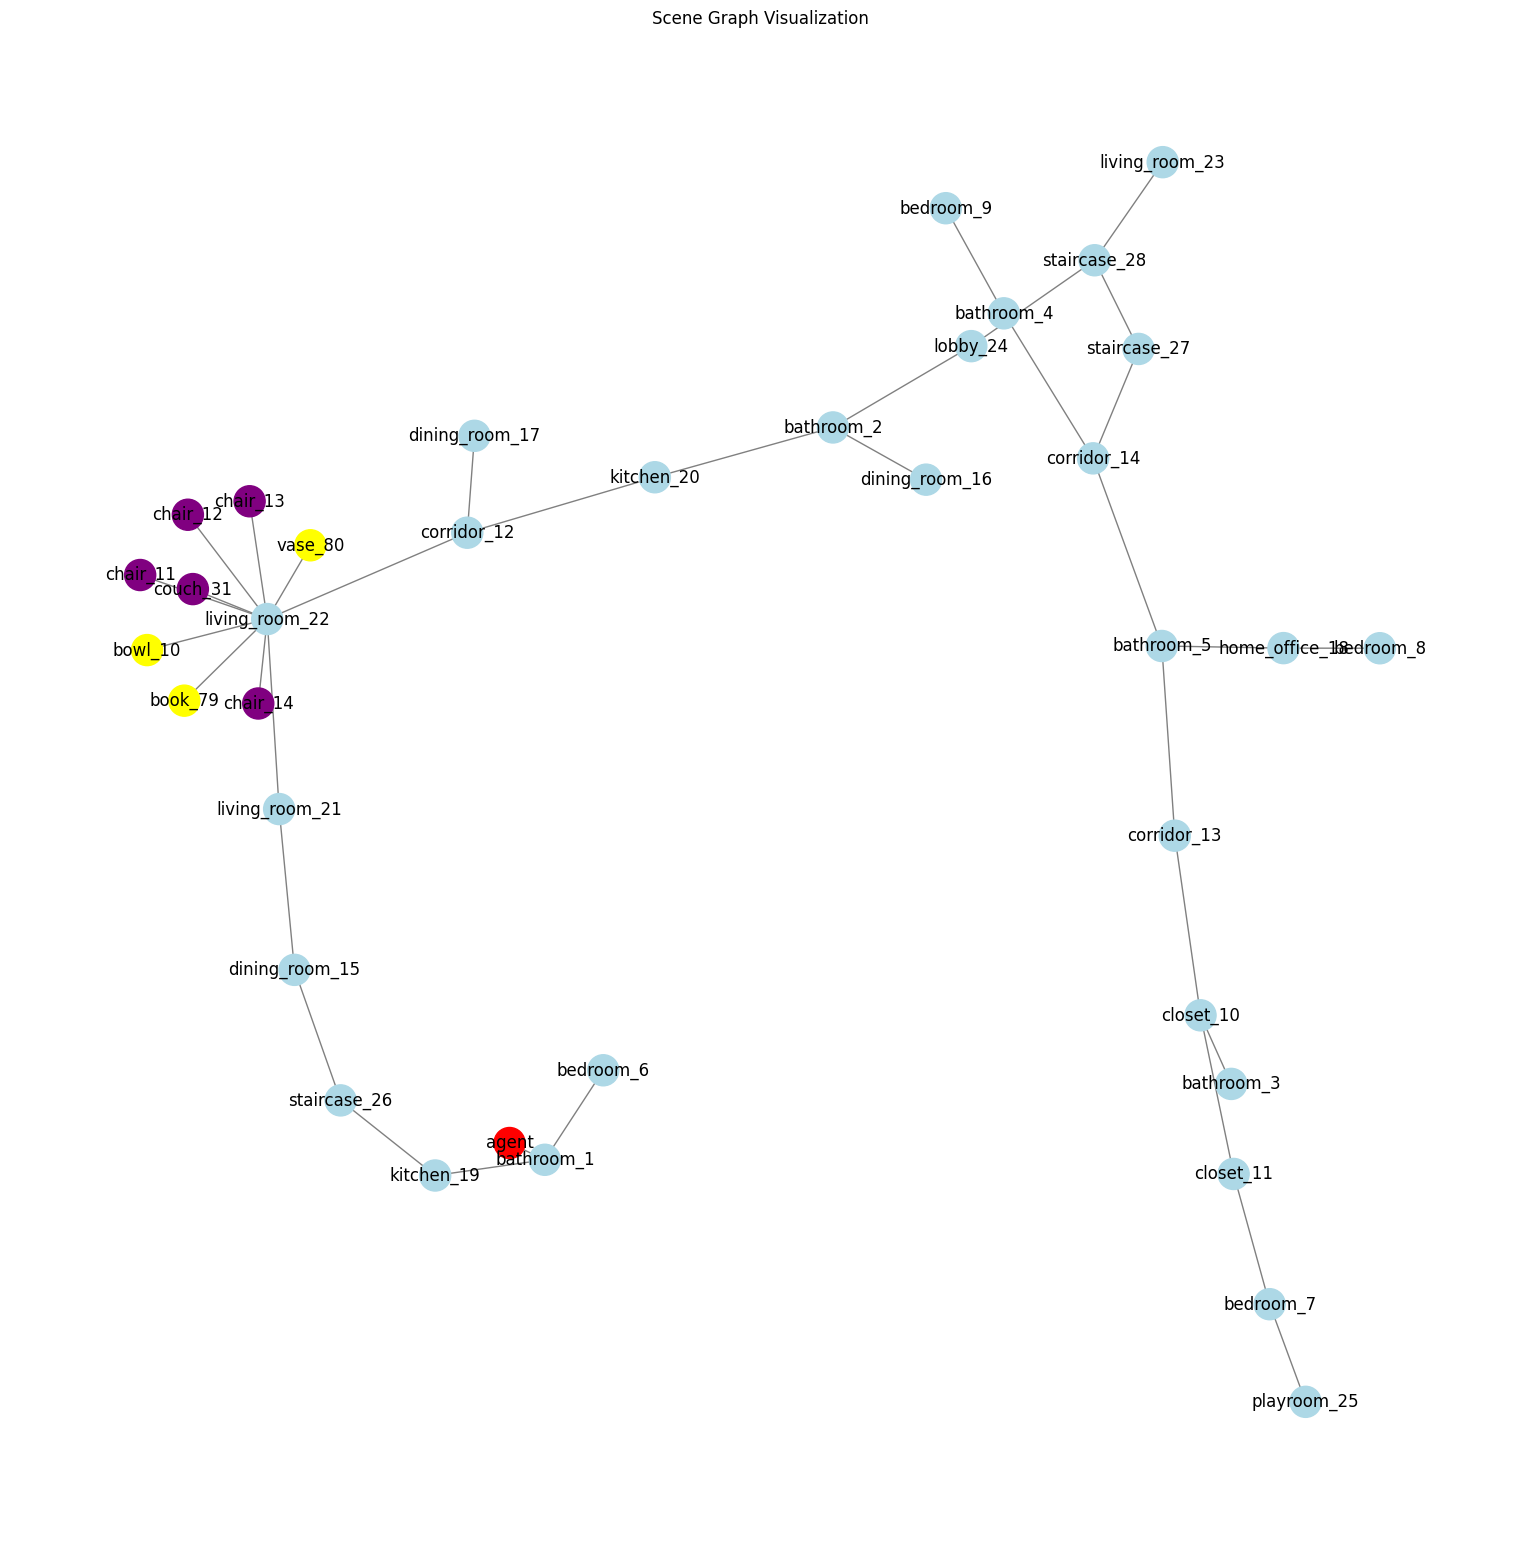

In [61]:

i = 0

task_description = instructions[i]["instruction"]


scenegraph = copy.deepcopy(scenegraph_original)

json_graph = prune_scenegraph(scenegraph, task_description, llm_gemini, graph_pruning_prompt_alt)
print(json_graph)

print(task_description)

plot_scene_graph_json(json_graph)


#room_graph = json.dumps(scenegraph.get_room_graph(), indent=4)

#print(room_graph)

In [21]:

i = 9

task_description = instructions[i]["instruction"]
instruction = instructions[i]

scenegraph = copy.deepcopy(scenegraph_original)

json_graph = json.dumps(scenegraph.get_scene_graph(), indent=4)
#json_graph = prune_scenegraph(scenegraph, task_description, llm_gemini, graph_pruning_prompt)
room_graph = json.dumps(scenegraph.get_room_graph(), indent=4)


#results = generate_plan_feecback(task_description, scenegraph, json_graph, llm_gemini, planner_prompt, max_retries=10)
#results = generate_plan_feedback(instruction, scenegraph, json_graph, room_graph, llm_gemini, planner_prompt, max_retries=10)


#results = generate_plan_feedback_gemini_timeout(instruction, scenegraph, json_graph, room_graph, llm_gemini, planner_prompt, max_retries=10)

results = await generate_plan_feedback_gemini_timeout(instruction, scenegraph, json_graph, room_graph, llm_gemini, planner_prompt_alt, max_retries=3)

print(results)

Attempt 1 to generate a valid plan...
Results:
  > Valid plan.
  > Valid plan.
✅ Plan is valid on attempt 1: ['goto(empty_room_10)', 'goto(corridor_6)', 'goto(staircase_14)', 'goto(corridor_7)', 'goto(dining_room_9)', 'goto(kitchen_11)', 'goto(dining_room_9)', 'goto(corridor_7)', 'goto(staircase_15)', 'goto(corridor_8)', 'goto(bathroom_3)', 'goto(bedroom_5)', 'pickup(tv_39)', 'goto(bathroom_3)', 'goto(corridor_8)', 'goto(staircase_15)', 'goto(corridor_7)', 'goto(living_room_12)', 'access(couch_28)', 'release(tv_39)']
['goto(empty_room_10)', 'goto(corridor_6)', 'goto(staircase_14)', 'goto(corridor_7)', 'goto(dining_room_9)', 'goto(kitchen_11)', 'goto(dining_room_9)', 'goto(corridor_7)', 'goto(staircase_15)', 'goto(corridor_8)', 'goto(bathroom_3)', 'goto(bedroom_5)', 'pickup(tv_39)', 'goto(bathroom_3)', 'goto(corridor_8)', 'goto(staircase_15)', 'goto(corridor_7)', 'goto(living_room_12)', 'access(couch_28)', 'release(tv_39)']
